# Import libraries requires

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import os
from glob import glob
import seaborn as sns
from PIL import Image
import keras
from keras.utils.np_utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.utils import resample

# Size default
SIZE = 32

# Loading dataset

In [39]:
# read the training dataset
train = pd.read_csv('data_labels_mainData.csv')

# display the first 5 rows
train.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


Text(0.5, 1.0, 'Cell Type')

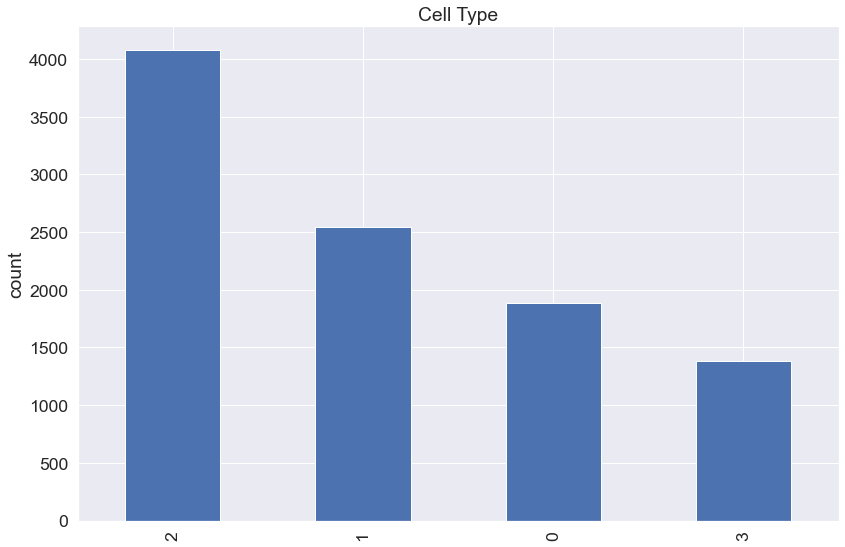

In [40]:
# Plot the datagram represent the number of data of each cellType 
fig = plt.figure(figsize=(30,20))
ax1=fig.add_subplot(221)
train['cellType'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('count')
ax1.set_title('Cell Type')

In [41]:
# count value of each cellType
train.cellType.value_counts()

2    4079
1    2543
0    1888
3    1386
Name: cellType, dtype: int64

# Data Preparation and Processing

In [42]:
# define new dataframe to store data of each cellType
train_0 = train[train['cellType'] == 0]
train_1 = train[train['cellType'] == 1]
train_2 = train[train['cellType'] == 2]
train_3 = train[train['cellType'] == 3]

In [43]:
# set the number of data of others cellType = number of data of cellType 2 (balance data)
train_0_balanced = resample(train_0, replace=True, n_samples = len(train_2), random_state = 42)
train_1_balanced = resample(train_1, replace=True, n_samples = len(train_2), random_state = 42)
train_3_balanced = resample(train_3, replace=True, n_samples = len(train_2), random_state = 42)


In [44]:
# combine back to a single dataframe
train_balanced = pd.concat([train_0_balanced,train_1_balanced, train_2, train_3_balanced])

In [45]:
# check the distribution: All cellTypes should be balanced 
print(train_balanced['cellType'].value_counts())

3    4079
2    4079
1    4079
0    4079
Name: cellType, dtype: int64


In [46]:
# shape of dataframe
train_balanced.shape

(16316, 6)

In [47]:
# display the first 5 rows of the new dataframe
train_balanced.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
6095,20563,37,20563.png,fibroblast,0,0
7209,19008,45,19008.png,fibroblast,0,0
4375,20207,23,20207.png,fibroblast,0,0
6768,3940,42,3940.png,fibroblast,0,0
6099,20567,37,20567.png,fibroblast,0,0


In [48]:
# drop unused columns
train_balanced = train_balanced.drop(['InstanceID', 'patientID',"cellTypeName","isCancerous"], axis = 1)

In [49]:
# dataframe after dropping column
train_balanced.head()

,ImageName,cellType
6095,20563.png,0
7209,19008.png,0
4375,20207.png,0
6768,3940.png,0
6099,20567.png,0


In [50]:
# read images based on ImageName from CSV file
path = "patch_images/"

# define the path and add as a new column 
train_balanced['path'] = path + train_balanced['ImageName']

# check the dataframe
train_balanced.head()

,ImageName,cellType,path
6095,20563.png,0,patch_images/20563.png
7209,19008.png,0,patch_images/19008.png
4375,20207.png,0,patch_images/20207.png
6768,3940.png,0,patch_images/3940.png
6099,20567.png,0,patch_images/20567.png


In [51]:
# Use the path to read image and convert image into numpy array
train_balanced['image'] = train_balanced['path'].map(lambda x: np.asarray(Image.open(x).resize((SIZE,SIZE))))

In [52]:
# check dataframe
train_balanced.head(1)

,ImageName,cellType,path,image
6095,20563.png,0,patch_images/20563.png,"[[[242, 164, 208], [236, 159, 206], [229, 153,..."


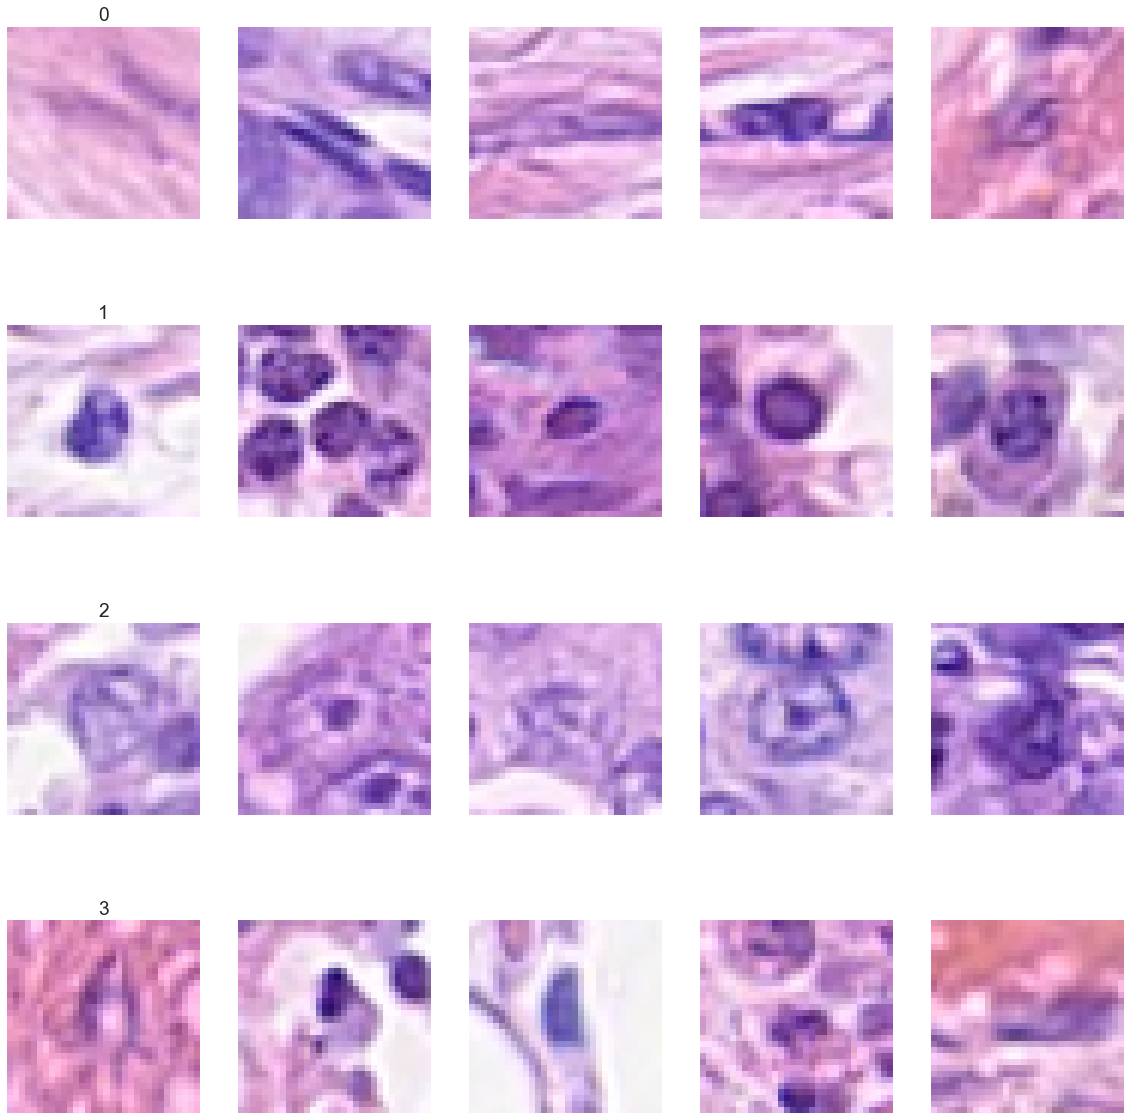

In [53]:
# Plotting some images of each category
fig, m_axs = plt.subplots(4, 5, figsize = (20, 21))
for n_axs, (type_name, type_rows) in zip(m_axs, train_balanced.sort_values(['cellType']).groupby('cellType')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(5, random_state=42).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

# Extract Training Data using Train_Split_Test

In [54]:
# X is value of images numpy array
X = np.asarray(train_balanced['image'].tolist())

# Scale values to 0:1
X = X/255.

In [55]:
# check the shape of X
X.shape

(16316, 32, 32, 3)

In [56]:
# Assign the label values to Y
Y = train_balanced['cellType']

In [57]:
# Convert the Y into 4 classes 
Y_cat = to_categorical(Y, num_classes = 4)

In [58]:
print(Y_cat)

[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 ...
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]


In [60]:
# Split data 80% training, 20% testing
x_train, x_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.2, random_state=42)

print("X_train shape", x_train.shape)
print("y_train shape", y_train.shape)
print("X_test shape", x_test.shape)
print("y_train shape", y_test.shape)

X_train shape (13052, 32, 32, 3)
y_train shape (13052, 4)
X_test shape (3264, 32, 32, 3)
y_train shape (3264, 4)


# Build CNN Model and Training model

In [25]:
num_classes = 4
# Define Model 
model = Sequential()

# Data input_shape
# Convolution Layer
model.add(Conv2D(32, (3,3), activation="relu", padding ='same',input_shape=(SIZE,SIZE,3)))
model.add(Conv2D(32, (3,3), activation="relu", padding = 'same'))
# Max Pooling 
model.add(MaxPool2D(pool_size=(2,2)))
# Dropout method
model.add(Dropout(0.2))

model.add(Conv2D(64,(3,3), activation="relu", padding ='same'))
model.add(Conv2D(64,(3,3), activation="relu", padding ='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3,3), activation="relu", padding ='same'))
model.add(Conv2D(128, (3,3), activation="relu", padding ='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.5))

# Flattening
model.add(Flatten())

# Hiden layer
model.add(Dense(512, activation = "relu")) 
model.add(Dropout(0.5))
model.add(Dense(128, activation = "relu")) 
model.add(Dropout(0.3))

# Ouput Layer with activation softmax, which good for multi-label classification
model.add(Dense(4, activation='softmax'))

# Summary of model 
model.summary()

# Model Compile
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0

In [26]:
# Training model 
batch_size = int(len(x_train)/100) 
epochs = 100

history = model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size = batch_size,
    validation_data=(x_test, y_test),
    verbose=2)

Epoch 1/100
101/101 - 26s - loss: 1.3675 - acc: 0.2886 - val_loss: 1.3236 - val_acc: 0.3244
Epoch 2/100
101/101 - 25s - loss: 1.3200 - acc: 0.3465 - val_loss: 1.0361 - val_acc: 0.5702
Epoch 3/100
101/101 - 25s - loss: 0.9618 - acc: 0.5775 - val_loss: 0.9397 - val_acc: 0.5974
Epoch 4/100
101/101 - 26s - loss: 0.8672 - acc: 0.6337 - val_loss: 0.8767 - val_acc: 0.6143
Epoch 5/100
101/101 - 26s - loss: 0.8443 - acc: 0.6433 - val_loss: 0.7411 - val_acc: 0.6930
Epoch 6/100
101/101 - 25s - loss: 0.8010 - acc: 0.6633 - val_loss: 0.7479 - val_acc: 0.6918
Epoch 7/100
101/101 - 26s - loss: 0.7838 - acc: 0.6797 - val_loss: 0.7612 - val_acc: 0.7117
Epoch 8/100
101/101 - 27s - loss: 0.7537 - acc: 0.6892 - val_loss: 0.6855 - val_acc: 0.7289
Epoch 9/100
101/101 - 26s - loss: 0.7424 - acc: 0.6977 - val_loss: 0.6841 - val_acc: 0.7255
Epoch 10/100
101/101 - 26s - loss: 0.7072 - acc: 0.7174 - val_loss: 0.6592 - val_acc: 0.7384
Epoch 11/100
101/101 - 26s - loss: 0.6695 - acc: 0.7342 - val_loss: 0.5750 - va

Epoch 90/100
101/101 - 27s - loss: 0.1155 - acc: 0.9595 - val_loss: 0.2475 - val_acc: 0.9485
Epoch 91/100
101/101 - 27s - loss: 0.1018 - acc: 0.9654 - val_loss: 0.2536 - val_acc: 0.9498
Epoch 92/100
101/101 - 26s - loss: 0.1250 - acc: 0.9581 - val_loss: 0.2797 - val_acc: 0.9366
Epoch 93/100
101/101 - 26s - loss: 0.1221 - acc: 0.9572 - val_loss: 0.2727 - val_acc: 0.9482
Epoch 94/100
101/101 - 28s - loss: 0.1143 - acc: 0.9608 - val_loss: 0.2346 - val_acc: 0.9430
Epoch 95/100
101/101 - 27s - loss: 0.1183 - acc: 0.9578 - val_loss: 0.2294 - val_acc: 0.9491
Epoch 96/100
101/101 - 27s - loss: 0.1083 - acc: 0.9641 - val_loss: 0.2319 - val_acc: 0.9510
Epoch 97/100
101/101 - 26s - loss: 0.1017 - acc: 0.9644 - val_loss: 0.2622 - val_acc: 0.9421
Epoch 98/100
101/101 - 26s - loss: 0.1021 - acc: 0.9655 - val_loss: 0.2357 - val_acc: 0.9498
Epoch 99/100
101/101 - 26s - loss: 0.1113 - acc: 0.9620 - val_loss: 0.2908 - val_acc: 0.9390
Epoch 100/100
101/101 - 27s - loss: 0.1438 - acc: 0.9506 - val_loss: 0

In [27]:
# Model Evaluating 
score = model.evaluate(x_test, y_test)
print('Test accuracy:', score[1])
print('Error rate:', score[0])

102/102 [==============================] - 2s 14ms/step - loss: 0.2584 - acc: 0.9467
Test accuracy: 0.9466911554336548
Error rate: 0.25839757919311523


In [28]:
# Save model
model.save('Label_CNN_Classifier.h5')

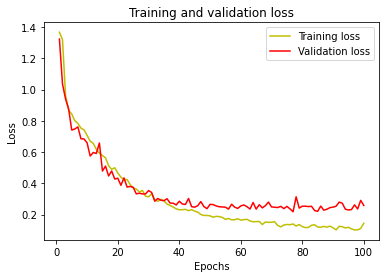

In [29]:
#plot the training and validation loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

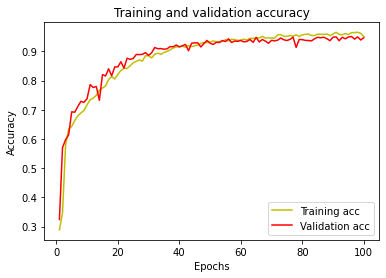

In [30]:
#plot the training and validation accuracy at each epoch
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [31]:
# Predict on test data
y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis = 1) 
# Convert test data to one hot vectors
y_true = np.argmax(y_test, axis = 1) 

In [32]:
#Print confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
print(cm)

[[783  10   8   7]
 [ 10 783  11  23]
 [ 30  42 758   6]
 [ 10   8   9 766]]


<AxesSubplot:>

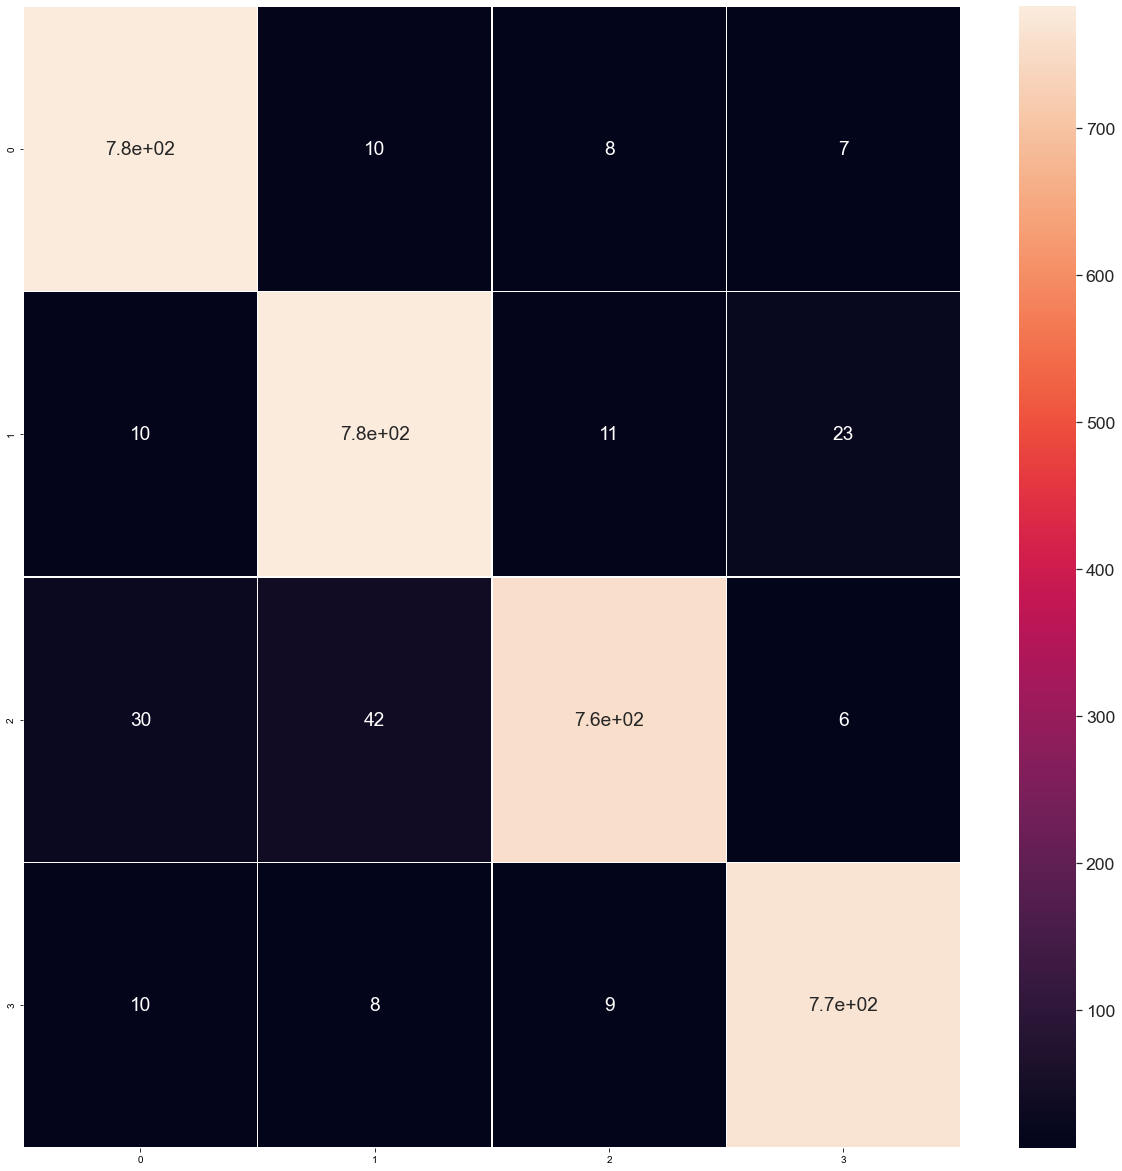

In [33]:
# Plot the heatmap
fig, ax = plt.subplots(figsize=(21,21))
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)

Text(0, 0.5, 'Fraction of incorrect predictions')

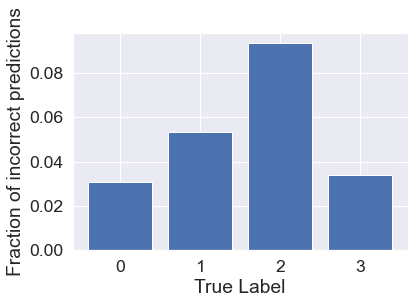

In [34]:
#PLot fractional incorrect misclassifications
incorr_fraction = 1 - np.diag(cm) / np.sum(cm, axis=1)
plt.bar(np.arange(4), incorr_fraction)
plt.xlabel('True Label')
plt.ylabel('Fraction of incorrect predictions')

The predict [[9.9998808e-01 4.5816741e-06 4.4349065e-07 6.8896129e-06]]
The class is [0]
The actual result is: 0


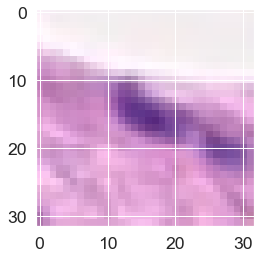

In [64]:
# Input index of image and predict
n = 222
img = X[n]
plt.imshow(img)

input_img = np.expand_dims(img, axis = 0)
y_pred = model.predict(input_img)
print("The predict", y_pred)
y_pre = np.argmax(y_pred, axis = 1) 
print("The class is", y_pre)
print("The actual result is:", Y[n])